In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from copy import deepcopy
from matplotlib import colors
from sklearn.metrics import mean_squared_error

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache
from rashomon.aggregate import find_te_het_partitions, find_feasible_sum_subsets


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data processing

### Read data

In [2]:
dta_fname = "../Data/Does_Price_Matter_AER_merged.dta"

raw_df = pd.read_stata(dta_fname)
colnames = raw_df.columns
print(colnames)

cols_to_keep = [
                'treatment', 'control',
                'ratio',
                # 'ratio2', 'ratio3',
                'size',
                # 'size25', 'size50', 'size100', 'sizeno',
                'ask',
                # 'ask1', 'ask2', 'ask3',
                # 'askd1', 'askd2', 'askd3',
                'amount', 'gave', 'amountchange',
                'red0'#, 'blue0'
               ]
df = raw_df[cols_to_keep]

df.head()

Index(['treatment', 'control', 'ratio', 'ratio2', 'ratio3', 'size', 'size25',
       'size50', 'size100', 'sizeno', 'ask', 'askd1', 'askd2', 'askd3', 'ask1',
       'ask2', 'ask3', 'amount', 'gave', 'amountchange', 'hpa', 'ltmedmra',
       'freq', 'years', 'year5', 'mrm2', 'dormant', 'female', 'couple',
       'state50one', 'nonlit', 'cases', 'statecnt', 'stateresponse',
       'stateresponset', 'stateresponsec', 'stateresponsetminc', 'perbush',
       'close25', 'red0', 'blue0', 'redcty', 'bluecty', 'pwhite', 'pblack',
       'page18_39', 'ave_hh_sz', 'median_hhincome', 'powner', 'psch_atlstba',
       'pop_propurban'],
      dtype='object')


,treatment,control,ratio,size,ask,amount,gave,amountchange,red0
0,0,1,Control,Control,Control,0.0,0,-45.0,0.0
1,0,1,Control,Control,Control,0.0,0,-25.0,0.0
2,1,0,1,"$100,000",1x,0.0,0,-50.0,0.0
3,1,0,1,Unstated,1x,0.0,0,-25.0,0.0
4,1,0,1,"$50,000",1x,0.0,0,-15.0,1.0


### Remove control

In [97]:
# avg_control = np.mean(df[df["control"] == 1]["amountchange"])
# df_treatment = df[df["treatment"] == 1]
# df_treatment.loc[:, "amountchange"] = df_treatment.loc[:, "amountchange"] - avg_control
df_treatment = deepcopy(df)
df_treatment = df_treatment.dropna()

### Process data

In [98]:
ratio_map = {"Control": 0, 1: 1, 2: 2, 3: 3}
size_map = {"Control": 0, "$25,000": 1, "$50,000": 2, "$100,000": 3, "Unstated": 4}
ask_map = {"Control": 0, "1x": 1, "1.25x": 2, "1.50x": 3}
redblue_map = {0: 1, 1: 2}


df_treatment.loc[:, "ratio"] = df_treatment.loc[:, "ratio"].map(ratio_map)
df_treatment.loc[:, "size"] = df_treatment.loc[:, "size"].map(size_map)
df_treatment.loc[:, "ask"] = df_treatment.loc[:, "ask"].map(ask_map)
df_treatment.loc[:, "red0"] = df_treatment.loc[:, "red0"].map(redblue_map)
df_treatment = df_treatment.astype({
    "ratio": np.int64, "size": np.int64, "ask": np.int64, "red0": np.int64})

df_treatment = df_treatment.drop(["treatment", "control"], axis=1)

df_treatment.head()

,ratio,size,ask,amount,gave,amountchange,red0
0,0,0,0,0.0,0,-45.0,1
1,0,0,0,0.0,0,-25.0,1
2,1,3,1,0.0,0,-50.0,1
3,1,4,1,0.0,0,-25.0,1
4,1,2,1,0.0,0,-15.0,2


# Analysis

### Rashomon

In [8]:
def print_pools(R_set, rashomon_profiles, idx, profiles, policies_mask, all_policies=None,
               policy_means=None):
    r_set = R_set[idx]
    
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_mask[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    if policy_means is not None:
        pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    else:
        pool_means_r = None
    
    for k, v in pi_pools_r.items():
        if all_policies is not None:
            print(k, ":", [all_policies[x] for x in v])
        else:
            print(k, ":", v)
        if pool_means_r is not None:
            print(pool_means_r[k])

Setup the policy and profile list

In [114]:
Z = df_treatment.to_numpy()
X = Z[:, [0, 1, 2, 6]] #- 1
y = Z[:, 3] / 100 # (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

M = 4
# R = np.array([3, 4, 3])
# R = np.array([4, 5, 4, 3])
R = np.array([4, 5, 4, 2])

num_data = X.shape[0]

if R[3] == 2:
    X[:, 3] -= 1



num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

In [115]:
policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

Setup the data and compute policy-wise means

In [116]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [117]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

0.022086720867208667


(array([95]),)

Run the Rashomon set

In [118]:
reg = 1e-7
# q_0 =  0.0075579
q =  0.007557
R_set, R_profiles = RAggregate(M, R, np.inf, D, y, q, reg=reg, bruteforce=True)
# R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

738


In [119]:
best_profile_counter = np.zeros(shape=(num_profiles,))

model_losses = []
model_sizes = []
model_mses = []
model_best_eff = []

model_pool_means = []
model_pools = []
model_policy_pool_map = []

best_loss = np.inf
best_policy_o = None

for r_set in R_set:
    pi_policies_profiles_r = {}

    loss_r = 0
    size_r = 0
    
    for profile, model_prof in enumerate(r_set):
        sigma_r_prof = R_profiles[profile].sigma[model_prof]
        loss_r_prof = R_profiles[profile].loss[model_prof]
        size_r_prof = R_profiles[profile].pools[model_prof]

        loss_r += loss_r_prof

        if sigma_r_prof is None and loss_r_prof == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_profiles_masked[k]))}
        else:
            size_r += size_r_prof
            _, pi_policies_r_k = extract_pools.extract_pools(policies_profiles_masked[profile], sigma_r_prof)
        
        pi_policies_profiles_r[profile] = pi_policies_r_k
    # print(pi_policies_r)
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    # print(pi_pools_r)
    # print(pool_means_r)

    mse_r = loss_r - reg * size_r
    
    model_losses.append(loss_r)
    model_sizes.append(size_r)
    model_mses.append(mse_r)
    model_best_eff.append(np.nanmax(pool_means_r))
    model_pool_means.append(pool_means_r)
    model_pools.append(pi_pools_r)
    model_policy_pool_map.append(pi_policies_r)
    # y_pred_r = metrics.make_predictions(D, pi_policies_r, pool_means_r)
    
    # best_pools = np.argwhere(pool_means_r == np.max(pool_means_r))[0]
    best_pools = np.argwhere(pool_means_r == np.nanmax(pool_means_r))[0]

    for best_pool in best_pools:
        best_policy_id = pi_pools_r[best_pool][0]
        best_policy = all_policies[best_policy_id]
        best_profile = tva.policy_to_profile(best_policy)
        profile_id = profile_map[best_profile]

        best_profile_counter[profile_id] += 1
        
        if loss_r < best_loss:
            best_loss = loss_r
            best_policy_o = best_policy
            print(best_loss, best_policy, size_r)
            # for k, v in pi_pools_r.items():
            #     print(k, ":", [all_policies[x] for x in v], v)
            #     print(pool_means_r[k])
            # print("---")

best_profile_freq = best_profile_counter / np.sum(best_profile_counter)
q_0 = best_loss

model_post_prob = np.exp(-np.array(model_losses))

print(f"Best model loss {best_loss} and best policy {best_policy_o}")

0.0075562069110773206 (2, 1, 3, 1) 37.0
Best model loss 0.0075562069110773206 and best policy (2, 1, 3, 1)


In [120]:
epsilon_est = np.max(model_losses) / np.min(model_losses) - 1
print(f"Epsilon = {epsilon_est}")

Epsilon = 0.00010491517999189348


In [121]:
for i in range(len(model_losses)):
    if model_sizes[i] > 10 or model_losses[i] > q_0:
        continue

    sqrd_err_best_pol_i = (model_best_eff[i] - true_best_eff)**2
    log_post_ratio = np.exp(- model_losses[i]) / np.exp(-best_loss)

    print(f"{model_sizes[i]}: {model_mses[i]:.5e} ({model_losses[i]:.5e}) & {sqrd_err_best_pol_i:.3e} & {log_post_ratio:.6e}")

Pooling red and blue states

1. "Treatment" -> Blue
2. "Control" -> Red

In [122]:
profiles_x, profiles_x_map = tva.enumerate_profiles(M-1)

te_rashomon_profiles = [[]] * len(profiles_x)

trt_arm_idx = 3

for x, profile_x in enumerate(profiles_x):
    print(f"Working on feature profile {tuple(list(profile_x) + ['x'])}")
    te_rashomon_x = []
    seen_pairs_bytes = []

    trt_profile = tuple(list(profile_x) + [1])
    ctl_profile = tuple(list(profile_x) + [0])

    trt_profile_idx = profile_map[trt_profile]
    ctl_profile_idx = profile_map[ctl_profile]

    trt_policies_ids = policies_ids_profiles[trt_profile_idx]
    ctl_policies_ids = policies_ids_profiles[ctl_profile_idx]
    tc_policies_ids = trt_policies_ids + ctl_policies_ids

    trt_policies = policies_profiles_masked[trt_profile_idx]
    ctl_policies = policies_profiles_masked[ctl_profile_idx]

    # Subset data
    mask = np.isin(D, tc_policies_ids)
    D_tc = D[mask].reshape((-1, 1))
    y_tc = y[mask].reshape((-1, 1))

    for R_est_idx, R_set_i in enumerate(R_set):
        # Get treatment and control partitions
        sigma_trt_R_set_idx = R_set_i[trt_profile_idx]
        sigma_trt_i = R_profiles[trt_profile_idx].sigma[sigma_trt_R_set_idx]
        sigma_ctl_R_set_idx = R_set_i[ctl_profile_idx]
        sigma_ctl_i = R_profiles[ctl_profile_idx].sigma[sigma_ctl_R_set_idx]

        if sigma_trt_i is None:
            trt_bytes_rep = str.encode("None")
        else:
            trt_bytes_rep = sigma_trt_i.tobytes()
        if sigma_ctl_i is None:
            ctl_bytes_rep = str.encode("None")
        else:
            ctl_bytes_rep = sigma_ctl_i.tobytes()
        bytes_rep = trt_bytes_rep + ctl_bytes_rep

        if bytes_rep in seen_pairs_bytes:
            continue
        seen_pairs_bytes.append(bytes_rep)

        # if sigma_trt_i is None or sigma_ctl_i is None:
        #     te_rashomon_x_i = RashomonSet(shape=None)
        #     te_rashomon_x_i.P_qe = [None]
        #     Q_ctl = R_profiles[trt_profile_idx].Q[sigma_trt_R_set_idx]
        #     Q_trt = R_profiles[ctl_profile_idx].Q[sigma_ctl_R_set_idx]
        #     te_rashomon_x_i.Q = np.append(te_rashomon_x_i.Q, Q_ctl + Q_trt)

        # else:
        #     # if sigma_trt_i is None:
        #     #     print("Trt is None")
        #     #     print(policies_ids_profiles[trt_profile_idx])
        #     #     print(policies_ids_profiles[ctl_profile_idx])
        #     #     print(tc_policies_ids)
        #     #     print(D_tc.shape)
        #     #     print(R)
        #     # if sigma_ctl_i is None:
        #     #     print("Ctl is None")
        #     te_rashomon_x_i = find_te_het_partitions(
        #         sigma_trt_i, sigma_ctl_i, trt_profile_idx, ctl_profile_idx, trt_policies, ctl_policies,
        #         trt_arm_idx, all_policies, policies_ids_profiles,
        #         D_tc, y_tc, policy_means,
        #         theta=q, reg=reg, normalize=num_data
        #     )

        # print(R_est_idx, len(te_rashomon_x_i.sigma))
        # for idx, sigma_idx in enumerate(te_rashomon_x_i.sigma):
        #     q_idx = te_rashomon_x_i.Q[idx]
        #     te_rashomon_x.append((sigma_idx, q_idx, sigma_trt_i, sigma_ctl_i))

    # te_rashomon_profiles[x] = te_rashomon_x

Working on feature profile (0, 0, 0, 'x')
Working on feature profile (0, 0, 1, 'x')
Working on feature profile (0, 1, 0, 'x')
Working on feature profile (0, 1, 1, 'x')
Working on feature profile (1, 0, 0, 'x')
Working on feature profile (1, 0, 1, 'x')
Working on feature profile (1, 1, 0, 'x')
Working on feature profile (1, 1, 1, 'x')


### Analyzing the rashomon set

First, we study model sizes

In [123]:
print(np.min(model_sizes), np.max(model_sizes))

9.0 65.0


In [124]:
R_set_pruned = []
model_losses_2 = []
model_sizes_2 = []
model_mses_2 = []
model_best_eff_2 = []
model_pool_means_2 = []
model_pools_2 = []
model_policy_pool_map_2 = []

threshold = 0.007557

for i in range(len(R_set)):
    if model_losses[i] > threshold:
        continue

    R_set_pruned.append(R_set[i])
    model_losses_2.append(model_losses[i])
    model_sizes_2.append(model_sizes[i])
    model_mses_2.append(model_mses[i])
    model_best_eff_2.append(model_best_eff[i])
    model_pool_means_2.append(model_pool_means[i])
    model_pools_2.append(model_pools[i])
    model_policy_pool_map_2.append(model_policy_pool_map[i])

model_losses_2 = np.array(model_losses_2)
model_sizes_2 = np.array(model_sizes_2)
model_post_prob_2 = np.exp(-model_losses_2)

rel_post_prob_ratio_2 = (model_post_prob_2 - np.max(model_post_prob)) / np.max(model_post_prob)

min_post_prob_ratio_2 = np.min(rel_post_prob_ratio_2)

print(min_post_prob_ratio_2)

-7.927604939616082e-07


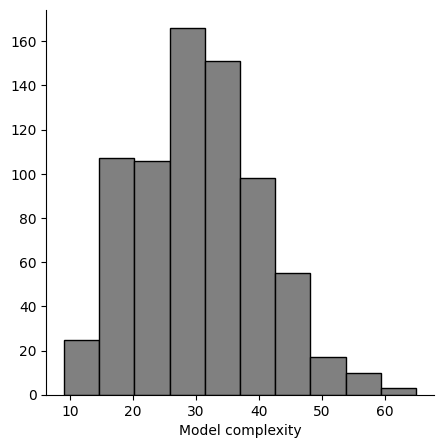

In [125]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

ax.set_xlabel("Model complexity")
ax.set_ylabel("")
ax.set_title("")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist_full.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [68]:
scaled_post_prob = model_post_prob - np.min(model_post_prob)
scaled_post_prob = model_post_prob / np.max(model_post_prob)

rel_post_prob_ratio = (model_post_prob - np.max(model_post_prob)) / np.max(model_post_prob)

In [49]:
from matplotlib import ticker

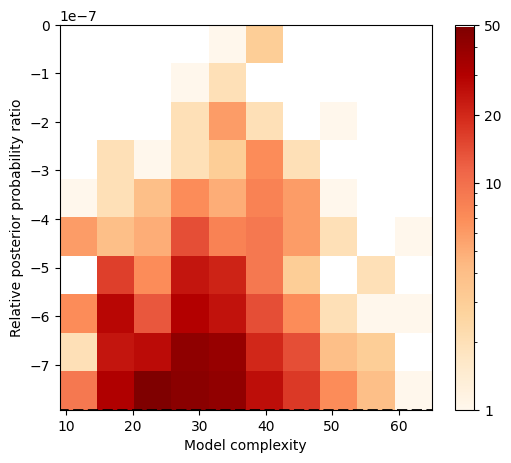

In [69]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, rel_post_prob_ratio, norm=colors.LogNorm(),
              # vmin=0, vmax=77,
             cmap="OrRd")

ax.plot([-2, 80], [min_post_prob_ratio_2, min_post_prob_ratio_2],
       color="black", linestyle="--", linewidth=2)


cb = fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)
ticks = [1, 10, 20, 50]
cb.set_ticks(ticks)
cb.set_ticklabels(ticks)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/price_charity/rset_2d_hist_cutoff.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_full.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

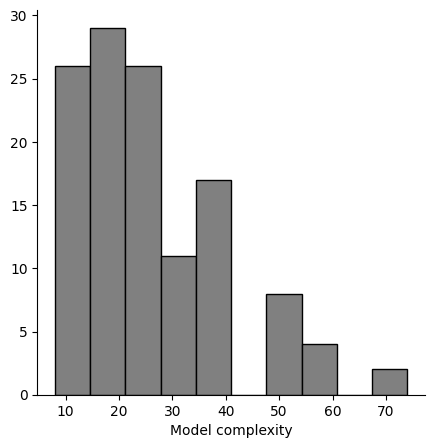

In [165]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes_2,
        color="grey", edgecolor="black")

ax.set_xlabel("Model complexity")
ax.set_ylabel("")
ax.set_title("")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

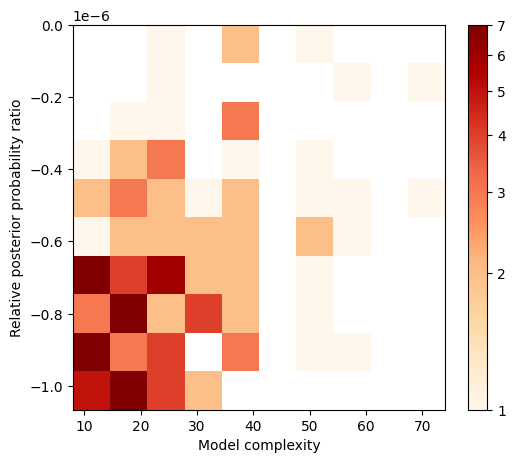

In [98]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes_2, rel_post_prob_ratio_2, norm=colors.LogNorm(),
             cmap="OrRd")

cb = fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)
cb.update_ticks()
ticks = [1, 2, 3, 4, 5, 6, 7]
cb.set_ticks(ticks)
cb.set_ticklabels(ticks)

ax.set_xlabel("Model complexity")
ax.set_ylabel("Relative posterior probability ratio")


# plt.savefig("../Figures/price_charity/rset_2d_hist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

Next, we look at the most common splits

In [130]:
# splits_1 = np.zeros(rashomon_profiles[1].sigma[0].shape)
splits_1 = np.zeros(rashomon_profiles[14].sigma[0].shape)
splits_2 = np.zeros(rashomon_profiles[15].sigma[0].shape)

price_match_1 = 0
price_match_2 = 0

for r_set in R_set_pruned:
    idx_1 = r_set[1]
    idx_2 = r_set[15]

    splits_1 += np.abs(rashomon_profiles[14].sigma[idx_1] - 1)
    splits_2 += np.abs(rashomon_profiles[15].sigma[idx_2] - 1)

    price_match_1 += np.max(rashomon_profiles[14].sigma[idx_1][1,:])
    price_match_2 += np.max(rashomon_profiles[14].sigma[idx_2][1,:])

splits_1 = splits_1 / len(R_set_pruned) * 100
splits_2 = splits_2 / len(R_set_pruned) * 100

price_match_1 = price_match_1 / len(R_set_pruned) * 100
price_match_2 = price_match_2 / len(R_set_pruned) * 100

In [131]:
splits_1, price_match_1

(array([[  0., 100.,  inf],
        [100.,   0.,   0.],
        [100.,   0.,  inf]]),
 100.0)

In [132]:
splits_2, price_match_2

(array([[ 61.11111111,  54.06504065,          inf],
        [100.        ,  24.11924119,  86.04336043],
        [ 70.86720867,  95.79945799,          inf],
        [         inf,          inf,          inf]]),
 90.5149051490515)

Estimating conditional effects

In [129]:
policies_present = np.sort(np.unique(D))

beta = np.zeros(num_policies)

for i, pool_means_i in enumerate(model_pool_means_2):

    beta_i = np.zeros(num_policies)
    
    for pool_id in range(len(pool_means_i)):
        for policy in model_pools_2[i][pool_id]:
            beta_i[policy] = pool_means_i[pool_id]

    beta += beta_i * model_post_prob_2[i]

beta /= np.sum(model_post_prob_2)
beta_subset = beta[policies_present]

beta_subset_sorted = list(np.sort(beta_subset))

policy_id_1 = np.where(beta == beta_subset_sorted[-1])[0][0]
policy_id_2 = np.where(beta == beta_subset_sorted[-2])[0][0]
policy_id_3 = np.where(beta == beta_subset_sorted[-3])[0][0]
policy_id_4 = np.where(beta == beta_subset_sorted[-4])[0][0]
policy_id_worst = np.where(beta == beta_subset_sorted[0])[0][0]

print(f"Best \t\t {all_policies[policy_id_1]} \t{beta_subset_sorted[-1]}")
print(f"Second Best \t {all_policies[policy_id_2]} \t{beta_subset_sorted[-2]}")
print(f"Third Best \t {all_policies[policy_id_3]} \t{beta_subset_sorted[-3]}")
print(f"Fourth Best \t {all_policies[policy_id_4]} \t{beta_subset_sorted[-4]}")
print(f"Worst \t\t {all_policies[policy_id_worst]} \t{beta_subset_sorted[0]}")

Best 		 (2, 1, 3, 1) 	0.018785119435557104
Second Best 	 (1, 4, 2, 1) 	0.015498305514303
Third Best 	 (3, 1, 1, 1) 	0.015241985920173895
Fourth Best 	 (2, 1, 1, 1) 	0.015055374049373465
Worst 		 (1, 1, 2, 0) 	0.006650313104924555


### Plot with Red vs Blue aligned with Control

In [214]:
red_control = (0, 0, 0, 0)
blu_control = (0, 0, 0, 1)

red_control_id = 0
blu_control_id = 1


red_policies = [idx for idx, pol in enumerate(all_policies) if np.min(pol[:3]) > 0 and pol[3] == 0]
blu_policies = [idx for idx, pol in enumerate(all_policies) if np.min(pol[:3]) > 0 and pol[3] == 1]

red_blu_df = []
for r in red_policies:
    red_blu_df.append([beta[r]*100, "Red", "indianred"])
for b in blu_policies:
    red_blu_df.append([beta[b]*100, "Blue", "dodgerblue"])

red_blu_df = pd.DataFrame(red_blu_df, columns=["Effect", "State", "marker_color"])
red_blu_df.head()

,Effect,State,marker_color
0,0.706297,Red,indianred
1,0.665031,Red,indianred
2,0.704850,Red,indianred
3,0.821452,Red,indianred
4,0.923098,Red,indianred


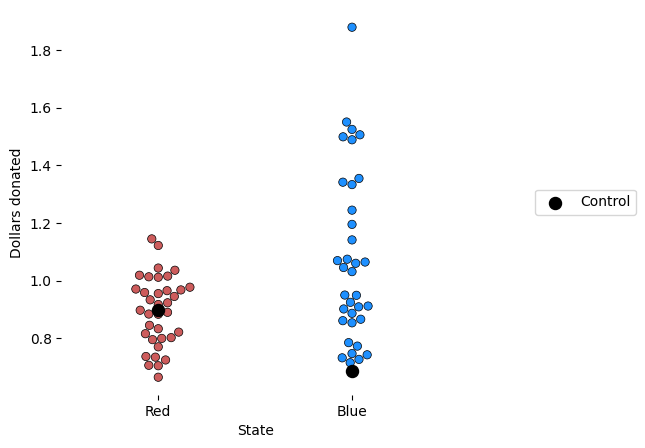

In [232]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


ax = sns.swarmplot(red_blu_df, x="State", y="Effect",
                   hue="State",
                   edgecolor="black",
                   palette=["indianred", "dodgerblue"],
                   size=6,
                   linewidth=0.5,
                  )
# ax.scatter([0]*len(red_policies), beta[red_policies]*100,
#            color="indianred", edgecolor="white", alpha=1,
#            label="Treatment (Red states)"
#           )
ax.scatter(0, beta[red_control_id]*100,
           color="black", edgecolor="black",
           zorder=3.1,
           s=75
          # label="Red Control"
          )


# ax.scatter([1]*len(blu_policies), beta[blu_policies]*100,
#            color="dodgerblue", edgecolor="white", alpha=1,
#            label="Treatment (Blue states)"
#           )
ax.scatter(1, beta[blu_control_id]*100,
           color="black", edgecolor="black",
           label="Control",
           zorder=3.1,
           s=75
          )

ax.set_xticks([0, 1], ["Red", "Blue"])
ax.set_xlim([-0.5, 1.5])
ax.set_ylabel("Dollars donated")


ax.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))


plt.show()

### Plot with all policies on same axis

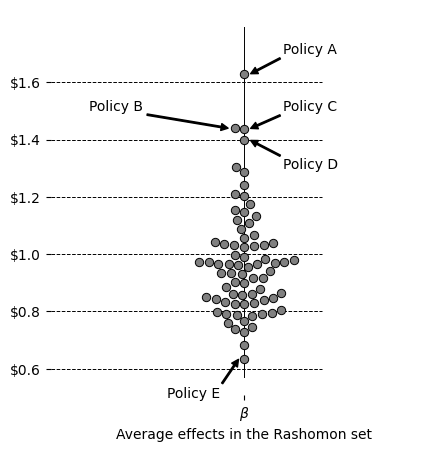

In [26]:
vert_line_x = [0, 0]
vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

hor_line_x = [-0.5, 0.2]
hor_line_y1 = [0.016, 0.016]
hor_line_y2 = [0.006, 0.006]
hor_line_y3 = [0.012, 0.012]
hor_line_y4 = [0.014, 0.014]
hor_line_y5 = [0.008, 0.008]
hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")

ax = sns.swarmplot(beta_subset, color="gray", edgecolor="black", linewidth=0.7,
                  size=6)#, saturation=1)

ax.annotate("Policy A", xy=(0.015, beta_subset_sorted[-1]), xytext=(0.1, 0.017),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy B", xy=(-0.04, beta_subset_sorted[-2]), xytext=(-0.4, 0.015),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy C", xy=(0.015, beta_subset_sorted[-3]), xytext=(0.1, 0.015),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy D", xy=(0.015, beta_subset_sorted[-4]), xytext=(0.1, 0.013),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01))
ax.annotate("Policy E", xy=(-0.015, beta_subset_sorted[0]), xytext=(-0.2, 0.005),
            arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5, shrink=0.01),
            label="yadadada")


ax.set_xlabel("Average effects in the Rashomon set")
ax.set_ylabel("")
ax.set_title("")
ax.set_xticks([0], [r"$\beta$"])
yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
ax.set_yticks(yticks, yticks_labels)

textstr = """
A: $2:$1, $25k, 1.5x, Blue
B: $3:$1, $25k, 1x, Blue
C: $2:$1, $25k, 1x, Blue
D: $3:$1, $25k, 1x, Blue
E: $1:$1, $50k, 1x, Red
"""
props = dict(facecolor='white', alpha=0.5,
            edgecolor='white')

# ax.text(0.5, 0.014, textstr, fontsize=10, verticalalignment='top', bbox=props)

# ax.legend([annot5.arrow_patch], (annot5["label"]))


# plt.savefig("../Figures/price_charity/conditional_effects.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [138]:
beta_red_1 = []
beta_red_2 = []
beta_blue_1 = []
beta_blue_2 = []

beta_categorical_df = []

beta_df_plot = []

policy_indicators = []

for beta_i in beta_subset:
    policy_id_i = np.where(beta == beta_i)[0][0]
    policy_i = all_policies[policy_id_i]
    this_indicator = [0, 0, 0]
    
    if policy_i[3] == 2:
        this_indicator[0] = 1
        if policy_i[0] == 1:
            this_indicator[1] = 0
            beta_blue_1.append(beta_i)
            beta_categorical_df.append([beta_i, "white", "dodgerblue", "dodgerblue", "black", "white"])
        else:
            this_indicator[1] = 1
            beta_blue_2.append(beta_i)
            beta_categorical_df.append([beta_i, "dodgerblue", "black", "dodgerblue", "black", "grey"])
    else:
        this_indicator[0] = 0
        if policy_i[0] == 1:
            this_indicator[1] = 0
            beta_red_1.append(beta_i)
            beta_categorical_df.append([beta_i, "white", "indianred", "indianred", "black", "white"])
        else:
            this_indicator[1] = 1
            beta_red_2.append(beta_i)
            beta_categorical_df.append([beta_i, "indianred", "black", "indianred", "black", "grey"])
    if policy_i[1] == 1:
        this_indicator[2] = 0
        beta_categorical_df[-1].append("white")
    else:
        this_indicator[2] = 1
        beta_categorical_df[-1].append("grey")

    policy_indicators.append(this_indicator)
    beta_df_plot.append([beta_i] + list(policy_i))

beta_categorical_df = pd.DataFrame(beta_categorical_df,
                                   columns=["beta", "color", "edge", "color_state", "edge_state", "color_ratio", "color_size"])
fill_colors = list(beta_categorical_df["color"])
edge_colors = list(beta_categorical_df["edge"])
fill_colors_state = list(beta_categorical_df["color_state"])
edge_colors_state = list(beta_categorical_df["edge_state"])
fill_colors_ratio = list(beta_categorical_df["color_ratio"])
edge_colors_ratio = list(beta_categorical_df["edge_state"])
fill_colors_size = list(beta_categorical_df["color_size"])

policy_indicators = np.array(policy_indicators)

beta_df_plot = pd.DataFrame(beta_df_plot,
                           columns=["beta", "ratio", "size", "ask", "state"])


In [139]:
beta_df_plot["ratio"] = beta_df_plot["ratio"].map({
    1: 1,
    2: 2,
    3: 2
})
beta_df_plot["size"] = beta_df_plot["size"].map({
    1: 1,
    2: 2,
    3: 2,
})
beta_df_plot["state"] = beta_df_plot["state"].map({
    1: "Red",
    2: "Blue"
})

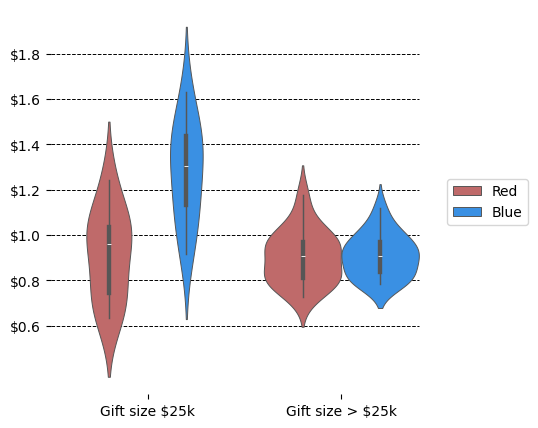

In [164]:
type = "size"


vert_line_x = [0, 0]
vert_line_x2 = [1, 1]
vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

hor_line_y1 = [0.016, 0.016]
hor_line_y2 = [0.006, 0.006]
hor_line_y3 = [0.012, 0.012]
hor_line_y4 = [0.014, 0.014]
hor_line_y5 = [0.008, 0.008]
hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


# ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
# ax.plot(vert_line_x2, vert_line_y, color="black", linewidth=0.7)

hor_line_x = [-0.5, 1.4]
hor_line_y_vals = [0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018]
for y_val in hor_line_y_vals:
    hor_line_y = [y_val, y_val]
    ax.plot(hor_line_x, hor_line_y, color="black", linewidth=0.7, ls="--", zorder=1)

# ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")


if type == "state":
    ax = sns.violinplot(x="state", y="beta", data=beta_df_plot[beta_df_plot["state"] == "Red"],
                        color="indianred",
                       linewidth=0.7,
                        dodge=True)
    ax = sns.violinplot(x="state", y="beta", data=beta_df_plot[beta_df_plot["state"] == "Blue"],
                        color="dodgerblue",
                       linewidth=0.7,
                        dodge=True)
elif type == "ratio":
    ax = sns.violinplot(x="ratio", y="beta", data=beta_df_plot,
                        hue="state",
                        palette=["indianred", "dodgerblue"],
                       linewidth=0.7,
                       dodge=True)
# elif type == "both":
#     ax = sns.violinplot(beta_subset, color="grey", #edgecolor=edge_colors,
#                        linewidth=0.7,
#                        # size=6,
#                        dodge=True)
elif type == "size":
    ax = sns.violinplot(x="size", y="beta", data=beta_df_plot,
                        hue="state",
                        palette=["indianred", "dodgerblue"],
                       linewidth=0.7,
                       dodge=True)


# ax.set_xlabel("Average effects in the Rashomon set")
ax.set_ylabel("")
ax.set_title("")
yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018]
yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
ax.set_yticks(yticks, yticks_labels)


# create manual symbols for legend
if type == "state":
    ax.set_xlabel("Political party")
    ax.set_xticks([0, 1], ["Red", "Blue"])
    plot_fname = "conditional_effects_state.png"
elif type == "ratio":
    ax.set_xlabel("")
    ax.set_xticks([0, 1], ["Price match \$1:\$1", "Price match > \$1:\$1"])
    plot_fname = "conditional_effects_ratio.png"
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
elif type == "size":
    ax.set_xlabel("")
    ax.set_xticks([0, 1], ["Gift size \$25k", "Gift size > \$25k"])
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
    plot_fname = "conditional_effects_size.png"
# elif type == "both":
#     # ax.legend(handles=[blue_1, blue_2, red_1, red_2], loc=(1, 0.35), frameon=False)
#     plot_fname = "conditional_effects_state_ratio.png"


# plt.savefig("../Figures/price_charity/" + plot_fname, dpi=300, bbox_inches="tight")

plt.show()

In [300]:
beta_red_unique = []
beta_blue_unique = []
policies_unique = []


for beta_i in beta_subset:
    policy_id_i = np.where(beta == beta_i)[0][0]
    policy_i = all_policies[policy_id_i]

    
    if policy_i[3] == 2:
        beta_blue_unique.append(beta_i)
        policies_unique.append(policy_i[:3])
    else:
        beta_red_unique.append(beta_i)

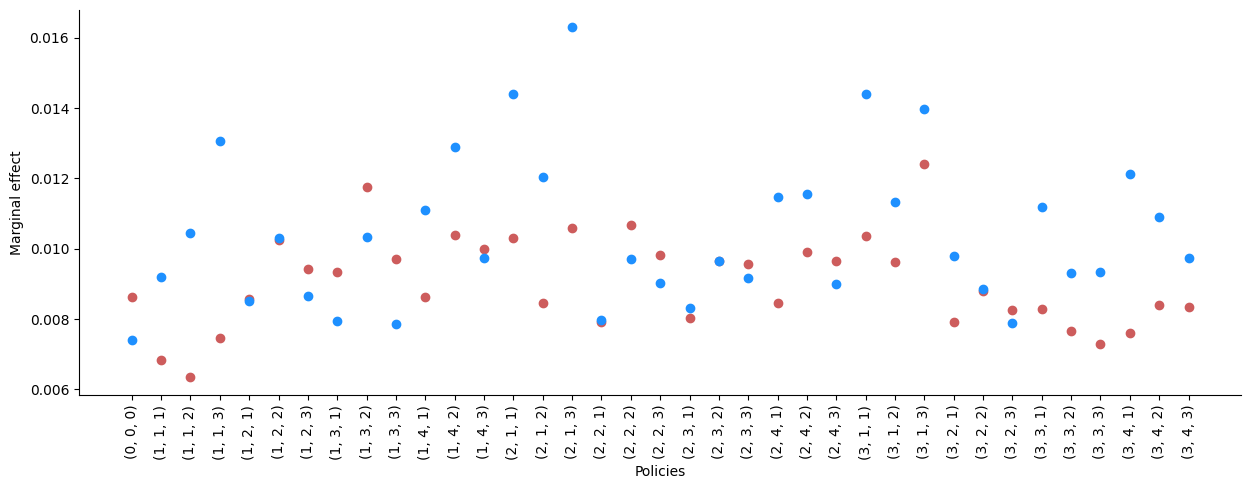

In [305]:
# vert_line_x = [0, 0]
# vert_line_y = [np.min(beta_subset) *0.9, np.max(beta_subset) * 1.1]

# hor_line_x = [-0.5, 0.2]
# hor_line_y1 = [0.016, 0.016]
# hor_line_y2 = [0.006, 0.006]
# hor_line_y3 = [0.012, 0.012]
# hor_line_y4 = [0.014, 0.014]
# hor_line_y5 = [0.008, 0.008]
# hor_line_y6 = [0.010, 0.010]

fig, ax = plt.subplots(figsize=(15,5))

ax.spines[['right', 'top']].set_visible(False)

x_vals = list(range(len(policies_unique)))

ax.scatter(x_vals, beta_red_unique, color="indianred", edgecolor="indianred")
ax.scatter(x_vals, beta_blue_unique, color="dodgerblue", edgecolor="dodgerblue")




# ax.plot(vert_line_x, vert_line_y, color="black", linewidth=0.7)
# ax.plot(hor_line_x, hor_line_y1, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y2, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y3, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y4, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y5, color="black", linewidth=0.7, ls="--")
# ax.plot(hor_line_x, hor_line_y6, color="black", linewidth=0.7, ls="--")




ax.set_xlabel("Policies")
ax.set_ylabel("Marginal effect")
ax.set_title("")
ax.set_xticks(x_vals, policies_unique, rotation="vertical")
# yticks = [0.006, 0.008, 0.010, 0.012, 0.014, 0.016]
# yticks_labels = ["$" + str(round(x * 100, 2)) for x in yticks]
# ax.set_yticks(yticks, yticks_labels)



# ax.legend(handles=[blue_1, blue_2, red_1, red_2], loc=(1, 0.4), frameon=False)



# plt.savefig("../Figures/price_charity/conditional_effects.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

## Epsilon vs Size of set and error

In [58]:
sorted_losses = np.sort(model_losses)
sorted_epsilon = sorted_losses / np.min(model_losses) - 1

num_models = np.arange(0, len(model_losses))+1
model_errors = sorted_losses * num_models

est_err = 1 / (num_models * np.exp(-sorted_losses))


our_threshold = q_0 / np.min(model_losses) - 1

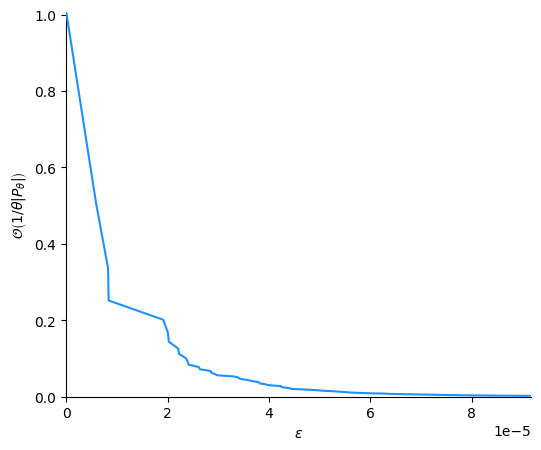

In [59]:


fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)


# ax.plot([0, np.max(sorted_epsilon)], [512, 512], color="grey", ls="--")
ax.plot([our_threshold, our_threshold], [0, 130], color="black", ls="--")
# ax.plot([0, our_threshold], [123, 123], color="black", ls="--")

ax.plot(sorted_epsilon, est_err,
        color="dodgerblue",
       zorder=3.1)

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\mathcal{O} \left( 1 / \theta |P_{\theta}| \right)$", rotation=90)

# ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(0, np.max(est_err))

# plt.savefig("../Figures/price_charity/eps_vs_est_error.png", dpi=300, bbox_inches="tight")

plt.show()

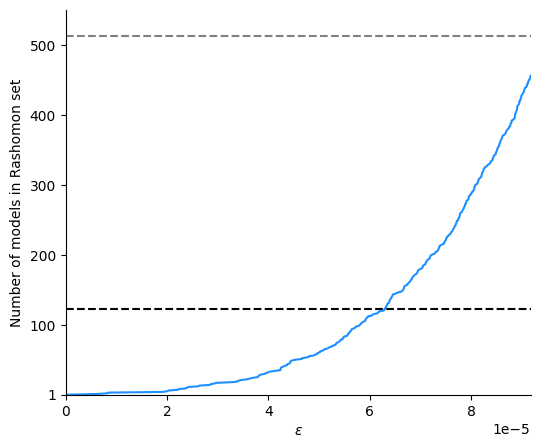

In [60]:
fig, ax = plt.subplots(figsize=(6,5))

ax.spines[['right', 'top']].set_visible(False)


ax.plot([0, np.max(sorted_epsilon)], [512, 512], color="grey", ls="--")
ax.plot([our_threshold, our_threshold], [0, 123], color="black", ls="--")
ax.plot([0, our_threshold], [123, 123], color="black", ls="--")

ax.plot(sorted_epsilon, num_models,
        color="dodgerblue")

ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel("Number of models in Rashomon set")

ax.set_yticks([1, 100, 200, 300, 400, 500])

ax.set_xlim(0, np.max(sorted_epsilon))
ax.set_ylim(1, 550)

# plt.savefig("../Figures/price_charity/eps_vs_size.png", dpi=300, bbox_inches="tight")

plt.show()

### Lasso

In [34]:
from sklearn import linear_model

In [204]:
G = tva.alpha_matrix(all_policies)
D_matrix = tva.get_dummy_matrix(D, G, num_policies)

In [205]:
lasso = linear_model.Lasso(1e-4, fit_intercept=False)
lasso.fit(D_matrix, y)
alpha_est = lasso.coef_
y_tva = lasso.predict(D_matrix)

In [208]:
sqrd_err = mean_squared_error(y, y_tva)
print(sqrd_err)

lasso_loss = sqrd_err + 1e-4 * np.linalg.norm(alpha_est, ord=1)
print(lasso_loss)

0.007557087681478236
0.007559423517002552


In [240]:
best_pol_effect_tva = np.max(y_tva)
sqrd_err_best_pol_tva = (true_best_eff - best_pol_effect_tva)**2
print(f"{sqrd_err_best_pol_tva:.3e}")

best_pol_idx_tva = np.unique(D[np.where(y_tva == best_pol_effect_tva)])
for idx in best_pol_idx_tva:
    print(idx, all_policies[idx])

1.079e-04
176 (2, 4, 2, 2)


In [147]:
0.0075579 / sqrd_err

1.0001074909483656

In [145]:
sqrd_err * 1.0001

0.007557843390246384

In [144]:
print(alpha_est.size)
alpha_est[np.nonzero(alpha_est)]

240


array([ 7.97690697e-03, -3.49831158e-04,  8.19950066e-03,  1.06300281e-03,
        9.43166838e-04, -8.49020667e-04,  8.90114104e-05,  6.60306624e-04,
        9.26149847e-04,  4.65184327e-04, -6.44947383e-04, -1.19132656e-03])

### Causal trees

In [182]:
from rashomon import causal_trees

from CTL.causal_tree_learn import CausalTree

In [246]:
ctl_res = causal_trees.ctl(M, R, D, y, D_matrix)
y_ctl = ctl_res[3]

In [243]:
np.unique(y_ctl)

array([0.00813755, 0.0091202 , 0.00980804, 0.01479656])

In [242]:
sqrd_err_ctl = mean_squared_error(y, y_ctl)
print(f"{sqrd_err_ctl:.3e}")

7.558e-03


In [241]:
best_pol_effect_ctl = np.max(y_ctl)
sqrd_err_best_pol_ctl = (true_best_eff - best_pol_effect_ctl)**2
print(f"{sqrd_err_best_pol_ctl:.3e}")

best_pol_idx_ctl = np.unique(D[np.where(y_ctl == best_pol_effect_ctl)])
for idx in best_pol_idx_ctl:
    print(idx, all_policies[idx])

5.315e-05
137 (2, 1, 1, 2)
140 (2, 1, 2, 2)
143 (2, 1, 3, 2)
197 (3, 1, 1, 2)
200 (3, 1, 2, 2)
203 (3, 1, 3, 2)
